In [1]:
#import excel file

import pandas as pd

sku_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')

sku_df=sku_df.drop(['Is Bundle?','Component 1','Component 2','Component 3','Component 4'], axis = 1)
sku_df.rename(columns = {'Diggs SKU':'code'}, inplace = True)

sku_df.head()

,code,Product Title,Variant,Category,Color,Size,Prod_variant
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,Collar- Ash-Large
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large
2,WSC040AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large
3,WSC008AALB,Collar,Collar - Large - Charcoal,Walk,Charcoal,Large,Collar- Charcoal-Large
4,WSC016AALL,Collar,Collar - Large - Lilac,Walk,Lilac,Large,Collar- Lilac-Large


In [2]:
sku_df.columns.isna()

array([False, False, False, False, False, False, False])

In [3]:
#importing Inventory products data 

import requests

import json

url = "https://api.cin7.com/api/v1/Products"
query_params = {
    "rows": 250,
    #"where": "createdDate<2023-03-05T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    #"where": "createdDate BETWEEN '2022-12-31T23:59:59Z' AND '2023-03-01T00:00:00Z'",
    "fields": "productOptions"
    #"fields": "StyleCode, productOptions"
}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

df = pd.json_normalize(data)

df.head()

,productOptions
0,"[{'id': 968, 'createdDate': '2023-03-16T14:25:..."
1,"[{'id': 967, 'createdDate': '2023-02-23T17:06:..."
2,"[{'id': 966, 'createdDate': '2023-02-23T17:05:..."
3,"[{'id': 965, 'createdDate': '2023-02-23T17:03:..."
4,"[{'id': 964, 'createdDate': '2023-02-23T17:02:..."


In [4]:
df = df.explode('productOptions')

# Use json_normalize to flatten the 'lineItems' column
df_product_options = pd.json_normalize(df['productOptions'])

# Apply function to rename columns
df_product_options = df_product_options.rename(columns=lambda x: x.split(".")[-1])

df.head(4)

,productOptions
0,"{'id': 968, 'createdDate': '2023-03-16T14:25:3..."
1,"{'id': 967, 'createdDate': '2023-02-23T17:06:3..."
2,"{'id': 966, 'createdDate': '2023-02-23T17:05:2..."
3,"{'id': 965, 'createdDate': '2023-02-23T17:03:5..."


In [5]:
df = df.reset_index(drop=True)
# Combine the flattened 'productOptions' DataFrame with the original DataFrame
df_data = pd.concat([df, df_product_options], axis=1)


# Drop the original 'lineItems' column
df_data = df_data.drop('productOptions', axis=1)
df_data.head(2).sort_values(by=['createdDate'])

,id,createdDate,modifiedDate,status,productId,code,barcode,productOptionCode,productOptionSizeCode,productOptionBarcode,...,specialsStartDate,specialDays,stockAvailable,stockOnHand,image,retailUSD,vipusd,wholesaleUSD,costUSD,specialPrice
1,967,2023-02-23T17:06:32Z,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,,MCP001A42G,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,16.30,0.0
0,968,2023-03-16T14:25:37Z,2023-03-16T14:31:18Z,Active,1007,AC0X5000V01X,,AC0X5000V01X,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,1.37,0.0


In [6]:
df_data.dtypes

df_data = df_data.drop(['modifiedDate', 'productOptionCode', 'productOptionSizeCode',
       'productOptionBarcode', 'barcode', 'supplierCode', 'productOptionSizeBarcode','optionWeight', 'size', 
        'retailPrice',
       'wholesalePrice', 'vipPrice', 'specialPrice', 'specialsStartDate',
       'specialDays',  'image', 'retailUSD',
       'vipusd', 'wholesaleUSD', 'costUSD', 'specialPrice'], axis=1)

df_data.head(3)

,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand
0,968,2023-03-16T14:25:37Z,Active,1007,AC0X5000V01X,,,,0.0,0.0
1,967,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,grey,XL,,0.0,0.0
2,966,2023-02-23T17:05:23Z,Active,1005,MCP001A40G,grey,Lg,,0.0,0.0


Now we have to dataframes:
                Inventory-df_data 
                SKU mapping - sku_mapping_df

In [7]:
stock_data = pd.merge(df_data, sku_df, on='code')
stock_data.head(3)
#stock_data.dtypes

,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand,Product Title,Variant,Category,Color,Size,Prod_variant
0,940,2022-11-14T22:04:31Z,Active,979,TPD001AOSC,,,,0.0,0.0,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Passenger- Charcoal-
1,939,2022-11-14T21:59:15Z,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--
2,938,2022-11-14T21:58:57Z,Active,977,WBD001AA2I,,,,0.0,0.0,Poop Bags,Poop Bags 2x Bundle,Walk,NaN,NaN,Poop Bags--


In [8]:
### March 18th

In [9]:
## Avilability by Prod Title

# group by products sold high level view

summarized_df = pd.DataFrame(stock_data.groupby(['Product Title']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head()

,Product Title,stockAvailable
5,Groov,46748.0
3,Collar,21716.0
13,Revol,20968.0
7,Leash,20962.0
4,Dispenser,14933.0


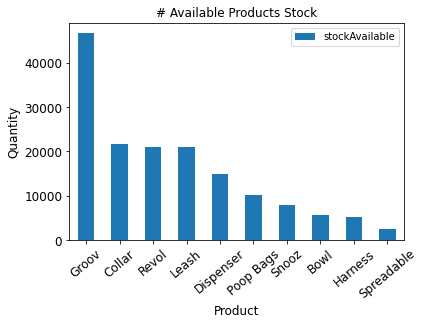

In [10]:
import matplotlib.pyplot as plt

fig1 = summarized_df.head(10).plot(kind = 'bar', x= 'Product Title' , y ='stockAvailable', title ="# Available Products Stock", figsize=(6, 4), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

In [11]:
summarized_var_df = pd.DataFrame(stock_data.groupby(['Product Title', 'Variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df = summarized_var_df.sort_values(by='stockAvailable', ascending=False)

summarized_var_df.head(5)

,Product Title,Variant,stockAvailable
52,Groov,Groov - Blush,16478.0
55,Groov,Groov - Navy,11851.0
57,Groov,Groov - Turquoise,10513.0
95,Poop Bags,Poop Bags,10063.0
54,Groov,Groov - Lilac,3855.0


In [12]:
#10 product variant which are lowest in stock

# group by products  Bottom 10

summarized_var_df_bottom_10 = pd.DataFrame(stock_data.groupby(['Product Title', 'Variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df_bottom_10 = summarized_var_df_bottom_10.sort_values(by='stockAvailable', ascending=True)

summarized_var_df_bottom_10.head(5)

,Product Title,Variant,stockAvailable
154,V1 Snooz,V1 Snooz - Small - Light Grey,-8.0
98,Refurbished Revol,Refurbished Revol - Medium - Ash,-6.0
99,Refurbished Revol,Refurbished Revol - Medium - Charcoal,-3.0
104,Refurbished Revol,Refurbished Revol - Small - Grey,-2.0
102,Refurbished Revol,Refurbished Revol - Small - Ash,-2.0


In [13]:
# No inventory stock

no_stock_avail_df = summarized_var_df[summarized_var_df["stockAvailable"] == 0]
no_stock_avail_df #products which have no inventory

,Product Title,Variant,stockAvailable
135,Revol/Snooz,Revol/Snooz Bundle - Medium - Ash,0.0
7,Bowl + Crate Clip,Crate Bowl + Clip S/M Charcoal,0.0
136,Revol/Snooz,Revol/Snooz Bundle - Medium - Charcoal,0.0
4,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,0.0
132,Revol/Snooz,Revol/Snooz Bundle - Large - Ash,0.0
152,V1 Snooz,V1 Snooz - Medium - Tan,0.0
151,V1 Snooz,V1 Snooz - Medium - Light Grey,0.0
149,Spreadable,Spreadable Treat Variety Pack,0.0
6,Bowl + Crate Clip,Crate Bowl + Clip S/M Ash,0.0
5,Bowl + Crate Clip,Crate Bowl + Clip I/L Charcoal,0.0


In [19]:
no_stock_avail_df.count()

Product Title     36
Variant           36
stockAvailable    36
dtype: int64

In [21]:
####Week 4 sales

In [108]:
#import pandas as pd
#import datetime
#s=pd.Timestamp.today().normalize()  

#today=s.strftime("%Y-%m-%d")
#print(today)
#days_28_period= s - datetime.timedelta(29)
#days_28_period=days_28_period.strftime("%Y-%m-%d")
#days_28_period

#####

import pandas as pd
import datetime

s=pd.Timestamp('2023-02-01').normalize()
today=s.strftime("%Y-%m-%d")
print(today)

days_28_period= s - datetime.timedelta(29)
days_28_period=days_28_period.strftime("%Y-%m-%d")
days_28_period


2023-02-01


'2023-01-03'

In [109]:
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
#import requests module
import requests
from requests.auth import HTTPBasicAuth
page=1
sales_data=[]
while(1):
    response = requests.get('https://api.cin7.com/api/v1/SalesOrders?rows=250&where= createdDate<'+str(today)+'T00:00:00Z and createdDate>'+days_28_period+'T23:59:59Z&fields=createdDate,lineItems&page='+str(page),auth = HTTPBasicAuth('DiggsIncUS', '9901f725991a42c4b8ea12917e3c21d9'))
    if not response.json():
        break
    #print (response.json())
    page_data=response.json()
    #separarting each object from the the output array and then appending it sales_Data to have an array of salesrecord objects
    sales_data += page_data
    #end of a single page
    #print("-------------------------------------------------") 
    #increasing the page value to iterate through all pages and get the data
    page+=1 
#print(sales_data)               


In [111]:
import pandas as pd

df_sales = pd.json_normalize(sales_data)
df_sales = df_sales.explode('lineItems').reset_index(drop=True)
df_sales = df_sales.dropna().reset_index(drop=True)

df_sales['code'] = ''
df_sales['qty'] = ''
for i in range(len(df_sales)):
    item = df_sales.loc[i, 'lineItems']
    if isinstance(item, dict) and 'code' in item and 'qty' in item:
        df_sales.loc[i, 'code'] = item['code']
        df_sales.loc[i, 'qty'] = int(item['qty'])
..
df_filtered = df_sales[['code', 'qty']]
df_filtered.head()


,code,qty
0,TRV001AOSG,1
1,PAD018AALG,1
2,GRO010AASIR,1
3,CRA022AALW-1,1
4,CRA022AALW-2,1


In [112]:

#matching the data from sales to the skumapping excel sheet to get product variants and their quantity sold
final_df=pd.merge(stock_data, df_filtered, on='code', how='left')


#final_df=final_df.groupby("Variant")["qty"].sum()
#final_df=final_df.sort_values(ascending=False)

#final_df= final_df.to_frame()

final_df.head(3)

final_df.to_excel('output1.xlsx') 

In [113]:
#summary = df[['stockAvailable', 'qty']].describe()
summary=final_df.groupby(["Product Title","Variant", "stockAvailable"], as_index=False)['qty'].sum()
#summary=Salevsinvent_df.groupby("Product_Title")['qty'].sum()

#adding sell through rate
summary['Sell_through_rate'] = summary['qty']/summary['stockAvailable']*100
summary.head()


,Product Title,Variant,stockAvailable,qty,Sell_through_rate
0,Bowl,Crate Bowl I/L Ash,1273.0,215,16.889238
1,Bowl,Crate Bowl I/L Charcoal,2038.0,25,1.226693
2,Bowl,Crate Bowl S/M Ash,636.0,280,44.025157
3,Bowl,Crate Bowl S/M Charcoal,1682.0,17,1.010702
4,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,0.0,156,inf


In [82]:
Salevsinvent_df=pd.concat([summarized_var_df, final_df], axis=1, join = 'outer')
# rename the columns
new_names = {'Product Title': 'Product Title', 'Variant': 'Variant_1', 'stockAvailable': 'Stock_Available',
             'code': 'code', 'Category': 'Category_1', 'Color': 'Color_1', 'Size': 'Size_1', 'Prod_variant': 'Prod_Variant'}
Salevsinvent_df = Salevsinvent_df.rename(columns=new_names)

Salevsinvent_df.sort_values(by = 'Stock_Available', ascending=False).reset_index().head(3)


,index,Product Title,Variant_1,Stock_Available,code,Product Title,Variant_1,Category_1,Color_1,Size_1,Prod_Variant,qty
0,52,Groov,Groov - Blush,16478.0,WSC003AASN,Collar,Collar - Small - Navy,Walk,Navy,Small,Collar- Navy-Small,1
1,55,Groov,Groov - Navy,11851.0,WSC003AASN,Collar,Collar - Small - Navy,Walk,Navy,Small,Collar- Navy-Small,1
2,57,Groov,Groov - Turquoise,10513.0,WSC011AASS,Collar,Collar - Small - Sage,Walk,Sage,Small,Collar- Sage-Small,1


In [81]:
#summary = df[['stockAvailable', 'qty']].describe()
summary=Salevsinvent_df.groupby("Product Title").sum()
#summary=Salevsinvent_df.groupby("Product_Title")['qty'].sum()
summary

ValueError: Grouper for 'Product Title' not 1-dimensional

,Product Title,Variant_1,code,Product Title,Variant_1,Category_1,Color_1,Size_1,Prod_Variant,qty
Stock_Available,,,,,,,,,,
-8.0,V1 Snooz,V1 Snooz - Small - Light Grey,CBD001AILA,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,Revol Accessories,Ash,I/L,Bowl + Crate Clip-Ash-I/L,1
-6.0,Refurbished Revol,Refurbished Revol - Medium - Ash,CBD001AILA,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,Revol Accessories,Ash,I/L,Bowl + Crate Clip-Ash-I/L,1
-3.0,Refurbished Revol,Refurbished Revol - Medium - Charcoal,CBD001AILA,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,Revol Accessories,Ash,I/L,Bowl + Crate Clip-Ash-I/L,1
-2.0,Refurbished RevolRefurbished Revol,Refurbished Revol - Small - AshRefurbished Rev...,CBD001AILACBD001AILA,Bowl + Crate ClipBowl + Crate Clip,Crate Bowl + Clip I/L AshCrate Bowl + Clip I/L...,Revol AccessoriesRevol Accessories,AshAsh,I/LI/L,Bowl + Crate Clip-Ash-I/LBowl + Crate Clip-Ash...,2
-1.0,Revol,Revol - Int - Ash,CBD001AILA,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,Revol Accessories,Ash,I/L,Bowl + Crate Clip-Ash-I/L,1
...,...,...,...,...,...,...,...,...,...,...
3855.0,Groov,Groov - Lilac,WSC003AASN,Collar,Collar - Small - Navy,Walk,Navy,Small,Collar- Navy-Small,1
10063.0,Poop Bags,Poop Bags,CBD001AILA,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,Revol Accessories,Ash,I/L,Bowl + Crate Clip-Ash-I/L,1
10513.0,Groov,Groov - Turquoise,WSC011AASS,Collar,Collar - Small - Sage,Walk,Sage,Small,Collar- Sage-Small,1


In [54]:
final_df=final_df.groupby("Variant")["qty"].sum()
Salevsinvent_df_sum=Salevsinvent_df_sum.sort_values(ascending=False)
Salevsinvent_df_sum

ValueError: Grouper for 'Product_Title' not 1-dimensional

In [14]:
### Old


###### Available Stock by Product Title

In [10]:
# group by products sold high level view

summarized_df = pd.DataFrame(stock_data.groupby(['Product Title']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head()

,Product Title,stockAvailable
5,Groov,46839.0
3,Collar,21729.0
7,Leash,20976.0
13,Revol,20396.0
4,Dispenser,12543.0


In [ ]:
import matplotlib.pyplot as plt

fig1 = summarized_df.head(10).plot(kind = 'bar', x= 'Product Title' , y ='stockAvailable', title ="# Available Products Stock", figsize=(6, 4), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

###### Top 10 product variant which are high in stock

In [12]:
summarized_var_df = pd.DataFrame(stock_data.groupby(['Product Title', 'Prod_variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df = summarized_var_df.sort_values(by='stockAvailable', ascending=False)

summarized_var_df.head(20)


,Product Title,Prod_variant,stockAvailable
46,Groov,Groov- Blush-,16491.0
49,Groov,Groov- Navy-,11863.0
51,Groov,Groov- Turquoise-,10521.0
87,Poop Bags,Poop Bags--,10095.0
48,Groov,Groov- Lilac-,3872.0
106,Revol,Revol- Grey-Medium,3721.0
107,Revol,Revol- Grey-Small,3677.0
50,Groov,Groov- Sage-,3238.0
68,Leash,Leash- Charcoal-Standard,3042.0
44,Dispenser,Dispenser- Sage-,2901.0


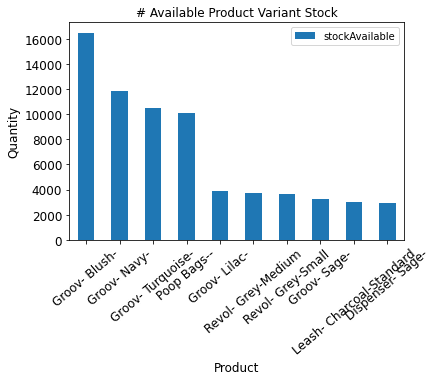

In [13]:
#import matplotlib.pyplot as plt

fig2 = summarized_var_df.head(10).plot(kind = 'bar', x= 'Prod_variant' , y ='stockAvailable', title ="# Available Product Variant Stock", figsize=(6, 4), legend=True, fontsize=12)

fig2.set_xlabel("Product", fontsize=12)
fig2.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()


######  10 product variant which are lowest in stock

In [14]:
# group by products  Bottom 10

summarized_var_df_bottom_10 = pd.DataFrame(stock_data.groupby(['Product Title', 'Prod_variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df_bottom_10 = summarized_var_df_bottom_10.sort_values(by='stockAvailable', ascending=True)

summarized_var_df_bottom_10.head(10)

,Product Title,Prod_variant,stockAvailable
88,Refurbished Revol,Refurbished Revol- Ash-Medium,-3.0
89,Refurbished Revol,Refurbished Revol- Ash-Small,-2.0
128,V1 Snooz,V1 Snooz- Light Grey-Small,-2.0
90,Refurbished Revol,Refurbished Revol- Charcoal-Medium,-1.0
113,Revol/Snooz,Revol/Snooz- Charcoal-Medium,0.0
112,Revol/Snooz,Revol/Snooz- Charcoal-Large,0.0
41,Dispenser,Dispenser- Grey-,0.0
111,Revol/Snooz,Revol/Snooz- Ash-Medium,0.0
108,Revol,Revol- Pine-Medium,0.0
52,Harness,Harness- Grey-Extra Small,0.0


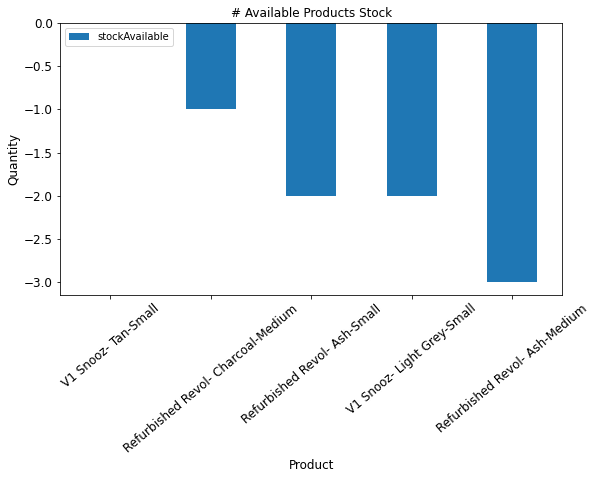

In [17]:

fig3 = summarized_var_df.tail(5).plot(kind = 'bar', x= 'Prod_variant' , y ='stockAvailable', title ="# Available Products Stock", figsize=(9, 5), legend=True, fontsize=12)

fig3.set_xlabel("Product", fontsize=12)
fig3.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()


###### Products with no current inventory

In [18]:
no_stock_avail_df = summarized_var_df[summarized_var_df["stockAvailable"] == 0]
no_stock_avail_df #products which have no inventory

,Product Title,Prod_variant,stockAvailable
6,Bowl + Crate Clip,Bowl + Crate Clip-Charcoal-I/L,0.0
115,Revol/Snooz,Revol/Snooz- Grey-Medium,0.0
127,V1 Snooz,V1 Snooz- Light Grey-Medium,0.0
129,V1 Snooz,V1 Snooz- Tan-Medium,0.0
113,Revol/Snooz,Revol/Snooz- Charcoal-Medium,0.0
4,Bowl + Crate Clip,Bowl + Crate Clip-Ash-I/L,0.0
7,Bowl + Crate Clip,Bowl + Crate Clip-Charcoal-S/M,0.0
5,Bowl + Crate Clip,Bowl + Crate Clip-Ash-S/M,0.0
114,Revol/Snooz,Revol/Snooz- Grey-Large,0.0
41,Dispenser,Dispenser- Grey-,0.0
